# Flock Dynamics Test Cases

This notebook is an extension of the pytest file used in TDD. It shows the results of two main functions in the library

- get_

The main reference of this project is Vicsek's model ["NOVEL TYPE OF PHASE TRANSITION IN A SYSTEM
OF SELF-DRIVEN PARTICLES"](https://arxiv.org/pdf/cond-mat/0611743.pdf)

## Dependencies

In [22]:
import numpy as np
import pylab as plt
from scipy.spatial import KDTree
from scipy.special import gamma, digamma
import os

In [11]:
def get_log_volume_ball_d_p(D, d, p):
    """
    Computes the log of the volume of a d-ball of diameter D, (d - dimension) in a p-InformationTheoryMetricsLib
    Reference: https://en.wikipedia.org/wiki/Volume_of_an_n-ball#Balls_in_Lp_norms
    NOTE: KSG definition of a unit ball MIGHT be diameter = 1.

    Parameters:
    D:  scalar
        diameter
    d:  scalar
        dimension
    p:  scalar
        p-norm value

    Returns:
    log_vol:    scalar
                logarithm of the d-ball, p-norm of diameter D
    """
    return d*np.log(gamma(1./p + 1)) + d*np.log(D) - np.log(gamma(1.*d/p + 1))

def get_entropy(x,p=2,k=1):
    """
    Computes the estimated entropy for a continuous distribution following the
    Kraskov, Stogbauer and Grassberger (KSG) method (PhysRevE.69.066138 - 2014)
    Reference: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
    Equation 20

    Parameters:
    x:  array-like
        points in the distribution
    p:  scalar (p>=1)
        p value of the p-norm.
            p = 1, Manhattan
            p = 2, Eucledian
            p = np.inf, Max
    k:  scalar
        k neighbor

    Returns:
    h:  scalar
        Approximated entropy for the distribution
    """

    if len(x.shape) == 2:
        n, d = x.shape
    else:
        raise Exception("Input data set should be a 2-dimensional array")

    if p>=1:
        log_c_d_p = get_log_volume_ball_d_p(1, d, p)
    else:
        #raise Exception("Input p must be p>=1")
        return('Nope')

    tree = KDTree(x)
    all_distances, indices = tree.query(x, k + 1, p=p)
    distances_to_k_neighbor = all_distances[:,-1]

    sum_log_distances_to_k_neighbor = np.sum(np.log(2*distances_to_k_neighbor))
    h = -digamma(k) + digamma(n) + log_c_d_p + (1.*d/n) * sum_log_distances_to_k_neighbor

    return(h)

## Functions

In [12]:
def get_periodic_conditions(r,L):
    """
    Computes periodic boundaries for the square LxL. If a coordinates it's outside the [0,L] interval,
    it substracts multiples of L and reports the reminder (TODO: extend behavior in other dimension.)
    
    Parameters:
    r:  array-like
        points in the distribution
    L:  scalar
        Length of the boundaries

    Returns:
    r_periodic:  array_like
        points in the distribution with periodic conditions.
    """
    r_periodic = np.mod(r,L)
    return(r_periodic)

In [13]:
def get_update_theta(r,theta,eps,noise_mag):
    """
    Updates the velocity angles of all the particles based on the average of neighbors inside the ball of radius eps
    (TODO: extend behavior in other dimension.)
    
    Parameters:
    r:  array-like
        points in the distribution
    theta:  array
        velocity angles/direction of the particles
    eps: scalar
        radius of the neighborhood 
    noise_mag: scalar
        magnitude of the noise added to the angles/directions

    Returns:
    theta:  array_like
        updated velocity angles/direction of the particles.
    """
    tree = KDTree(r)
    l_theta = []
    for item in r:
        neighbors = tree.query_ball_point(item,eps)
        l_theta.append(np.mean(theta[neighbors])+np.random.uniform()*2*np.pi*noise_mag)
    return(np.array(l_theta))

In [14]:
def get_update_r(r,theta,vdt,L):
    """
    Updates the position of all the particles based on the current position, the updated angles and (time*velocity) 
    interval with periodic conditions. (TODO: extend behavior in other dimension.)
    
    Parameters:
    r:  array-like
        points in the distribution
    theta:  array
        velocity angles/direction of the particles
    vdt: scalar
        velocity*time interval
    L: scalar
        length of the boundary
        
    Returns:
    r:  array_like
        updated velocity angles/direction of the particles.
    """
    r = r + vdt*np.array([np.cos(theta),np.sin(theta)]).T
    return(get_periodic_conditions(r,L))

In [15]:
def get_update_iteration(r,theta,eps,noise_mag,vdt,L):
    """
    Updates the position and orientation of all the particles. (TODO: extend behavior in other dimension.)
    
    Parameters:
    r:  array-like
        points in the distribution
    theta:  array
        velocity angles/direction of the particles
    eps: scalar
        radius of the neighborhood 
    noise_mag: scalar
        magnitude of the noise added to the angles/directions
    vdt: scalar
        velocity*time interval
    L: scalar
        length of the boundary
        
    Returns:
    r:  array_like
        updated velocity angles/direction of the particles.
    theta:  array_like
        updated velocity angles/direction of the particles  
    """
    theta = get_update_theta(r,theta,eps,noise_mag)
    r = get_update_r(r,theta,vdt,L)
    return(r,theta)

In [23]:
def get_flock_dynamics(N,L,noise_mag,eps,vdt,N_iter):
    """
    Simulation of flock dynamics following Vicsek's model.
    - creates random distribution of points in the [0,L]X[0,L], uniform. Assign random direction theta 
    - update theta and r
    iterate 
    (TODO: check behavior in other dimension.)
    
    Parameters:
    N: scalar
        Number of particles
    eps: scalar
        radius of the neighborhood 
    noise_mag: scalar
        magnitude of the noise added to the angles/directions
    vdt: scalar
        velocity*time interval
    L: scalar
        length of the boundary
    N_iter: scalar
        number of iterations
        
    Returns:
    """
    r = L*np.random.uniform(size=(N,2))
    theta = 2*np.pi*np.random.uniform(size=N)

    for iteration in range(N_iter):
        r,theta = get_update_iteration(r,theta,eps,noise_mag,vdt,L)

        plt.figure(figsize=(10,10))
        plt.scatter(*(zip(*r)))
        plt.xlim([0,L])
        plt.ylim([0,L])
        plt.axis('off')
        plt.savefig('flock_iteration_' + str(iteration).zfill(10) + '.png')
    os.system('convert -delay 10 -loop 0 flock_iteration_*.png flock_dynamics.gif')

In [20]:
def get_flock_dynamic_run_entropy_plots_split(noise_mag, eps, vdt, N_iter):
    r = L*np.random.uniform(size=(N,2))
    theta = 2*np.pi*np.random.uniform(size=N)
    lIT = []
    lENTR = []
    for iteration in range(N_iter):
        #noise_mag = 0.1
        #eps = 10.
        #vdt = 100.
        r,theta = get_update_iteration(r,theta)
        lIT.append(iteration)
        entropy = get_entropy(r)
        lENTR.append(entropy)
        if iteration % 10 == 0 or 1>0:
            #plt.figure(figsize=(10,10))
            #plt.scatter(*(zip(*r)))
            #plt.xlim([0,L])
            #plt.ylim([0,L])
            #plt.axis('off')
            #plt.show()
            #plt.savefig('flock_iteration_' + str(iteration).zfill(10) + '.png')
            
            fig, axs = plt.subplots(2,1,figsize=(10,12),gridspec_kw={'height_ratios': [1, 2]})
            #fig.suptitle('Vertically stacked subplots')
            axs[0].scatter(lIT,lENTR)
            axs[0].set_xlim([0,N_iter])
            axs[0].set_yticks([])
            #axs[1].scatter(df[0],df[1],c=np.argmax(P_I_C,axis=1))
            axs[1].scatter(*(zip(*r)))
            axs[1].set_xlim([0,L])
            axs[1].set_ylim([0,L])
            fig.savefig('flock_iteration_entropy_' + str(iteration).zfill(10) + '.png')

            
    return(lIT, lENTR)

/var/folders/22/9nvz87t91ylc5tn1tdyzy2y80000gn/T/ipykernel_65404/4097881934.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


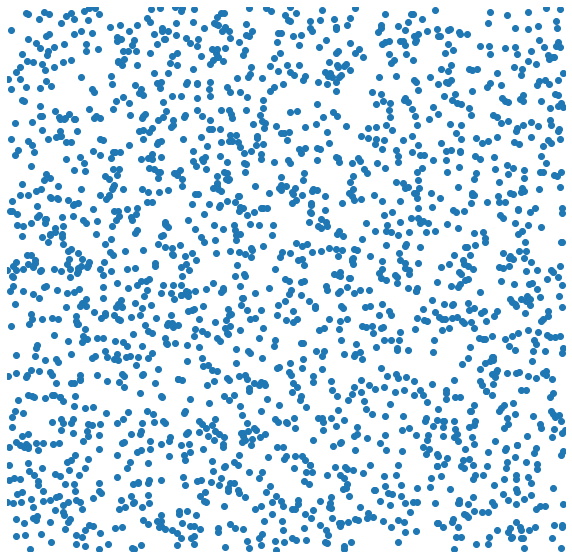

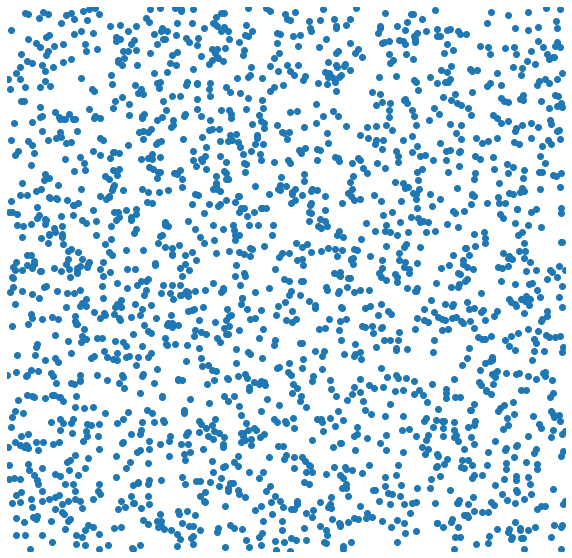

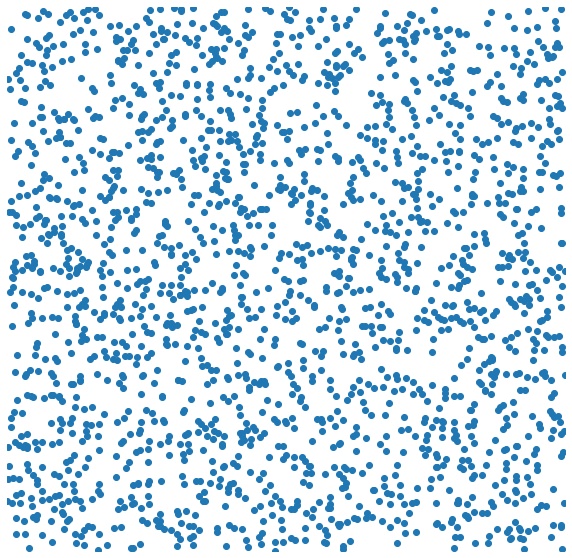

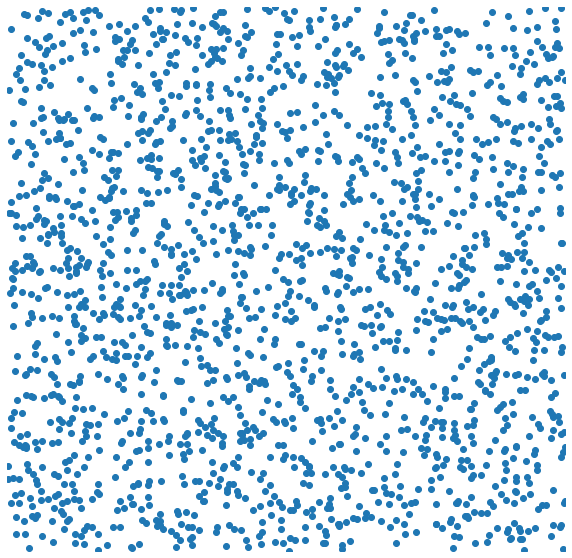

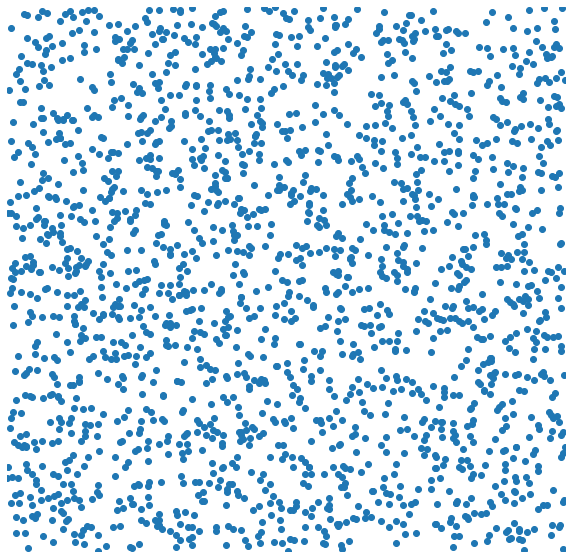

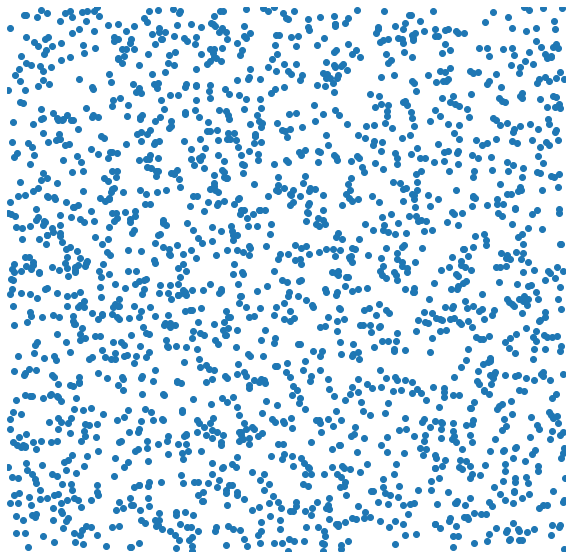

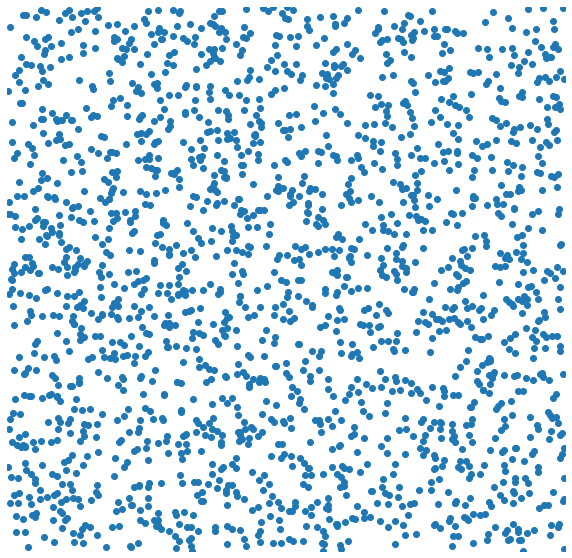

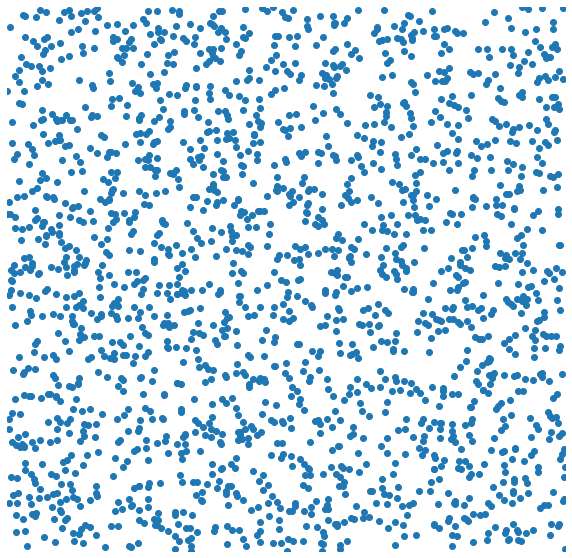

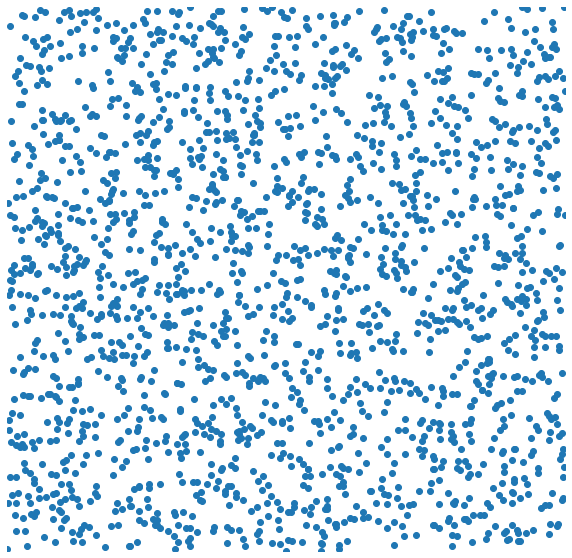

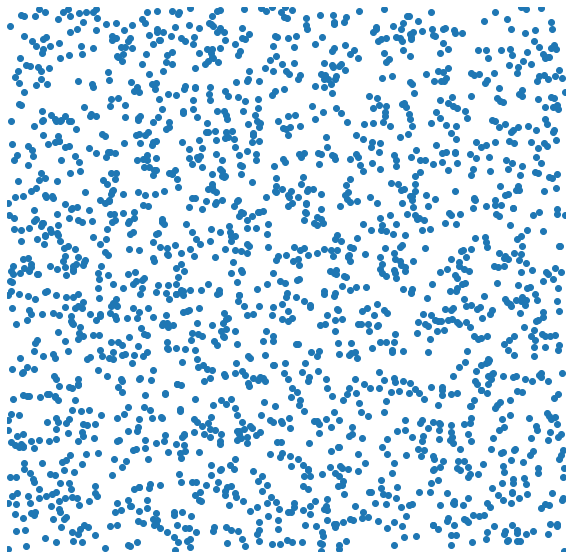

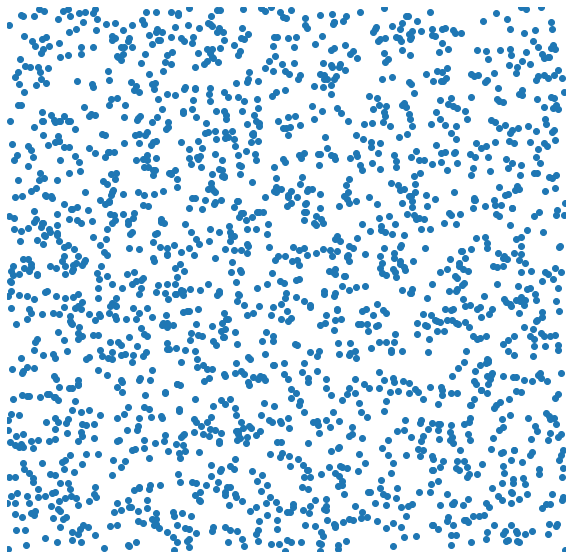

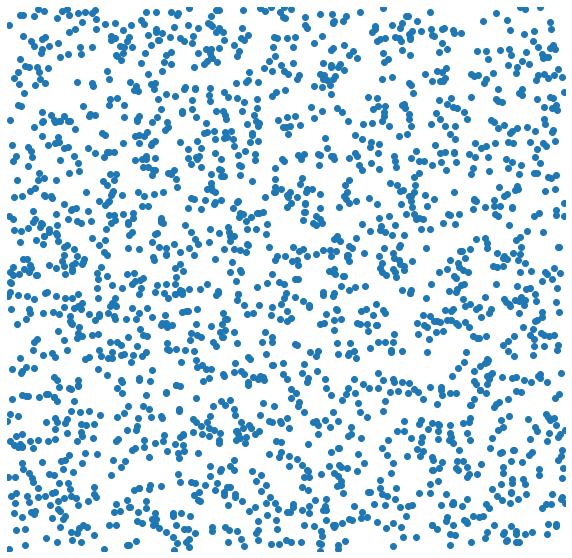

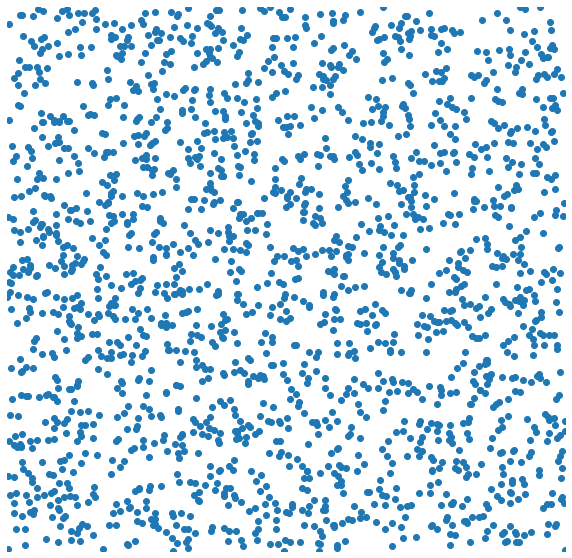

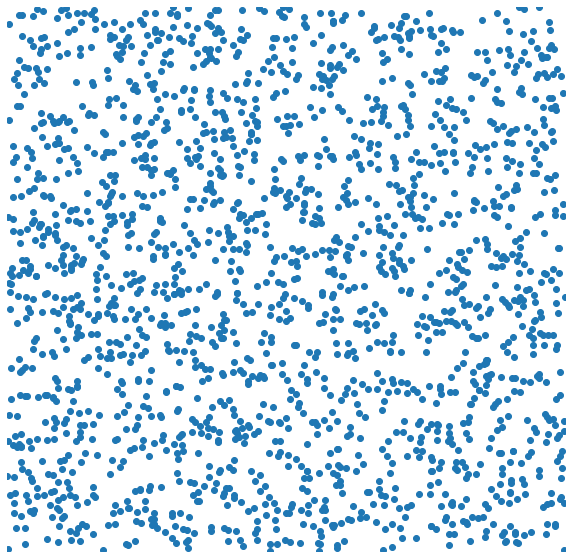

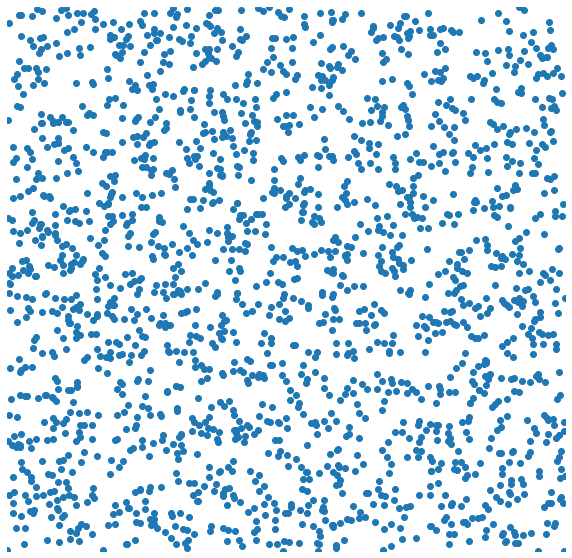

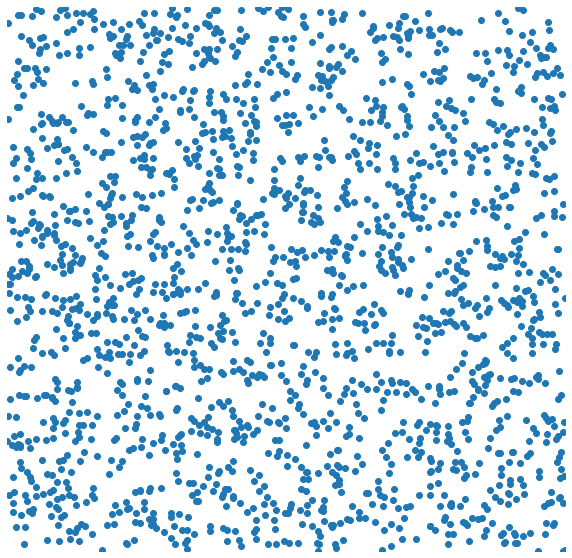

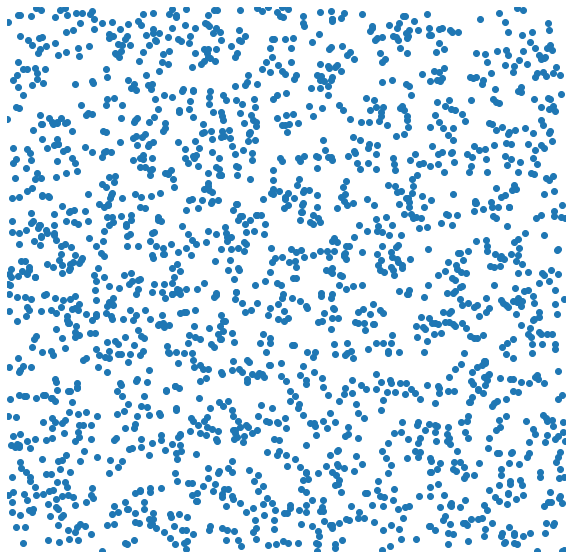

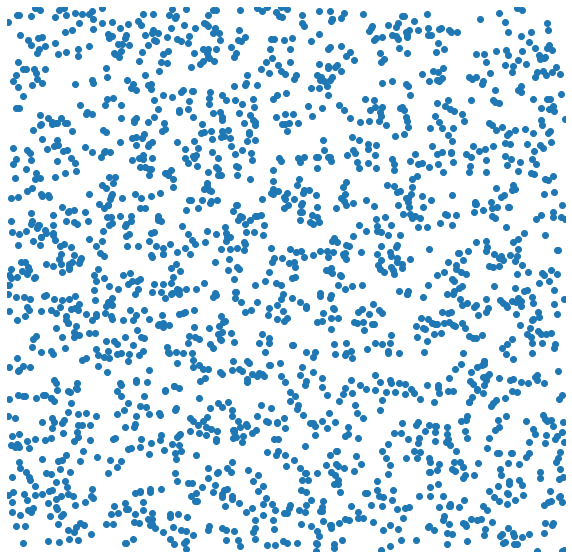

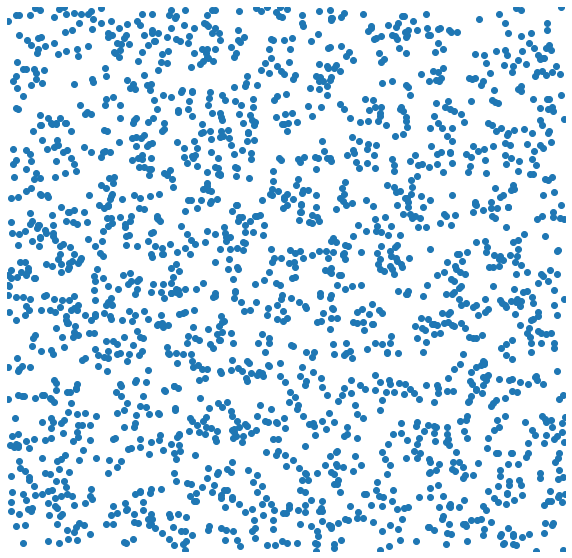

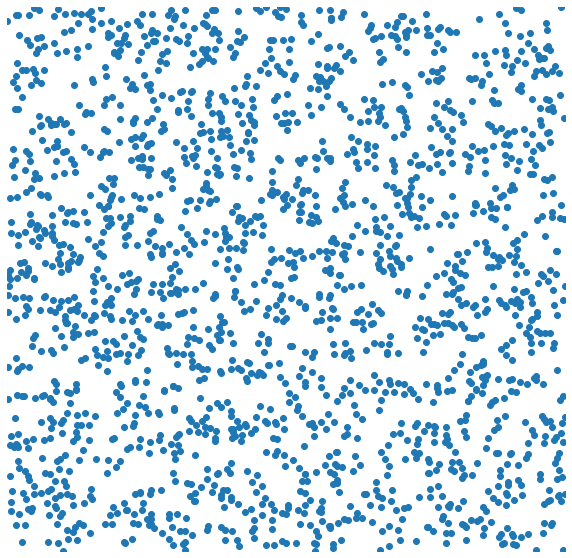

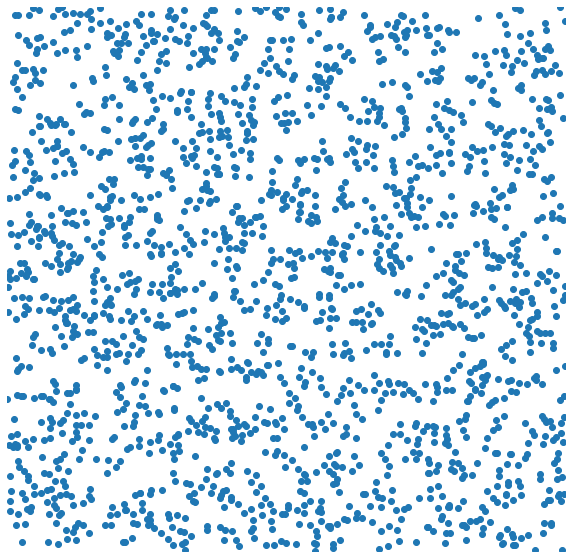

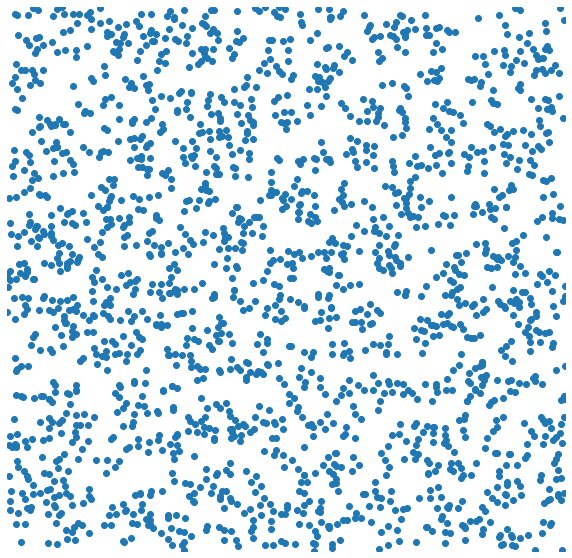

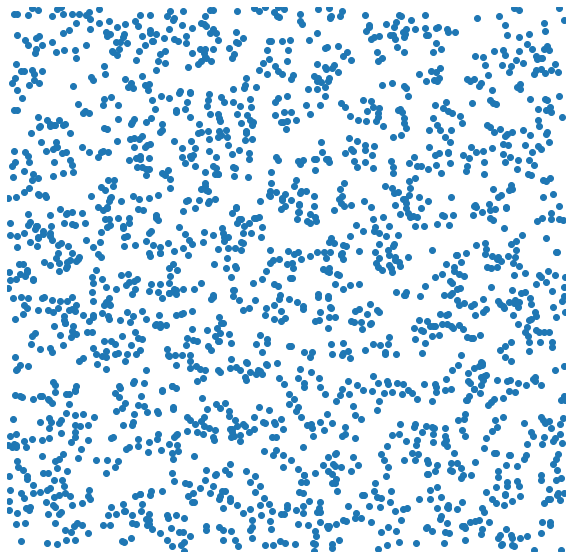

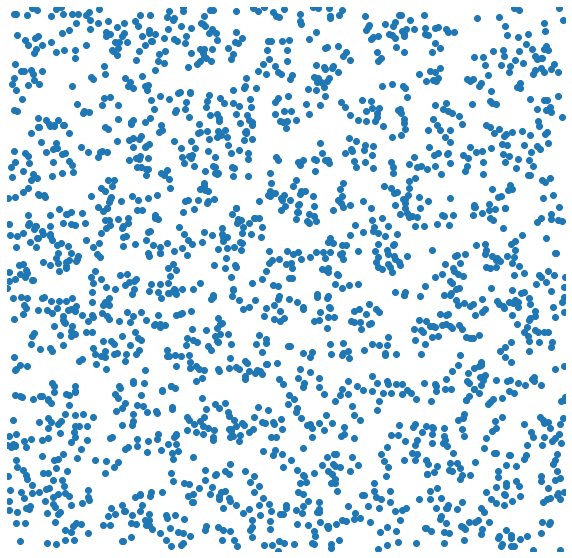

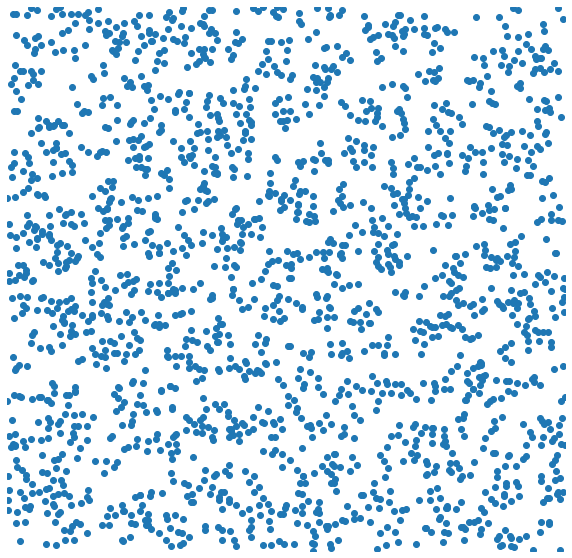

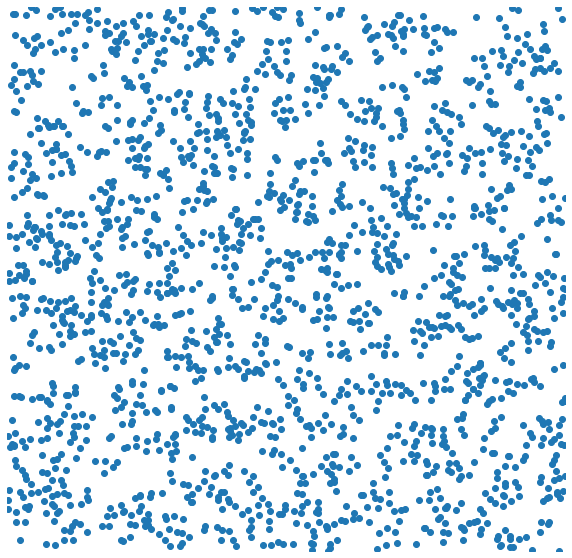

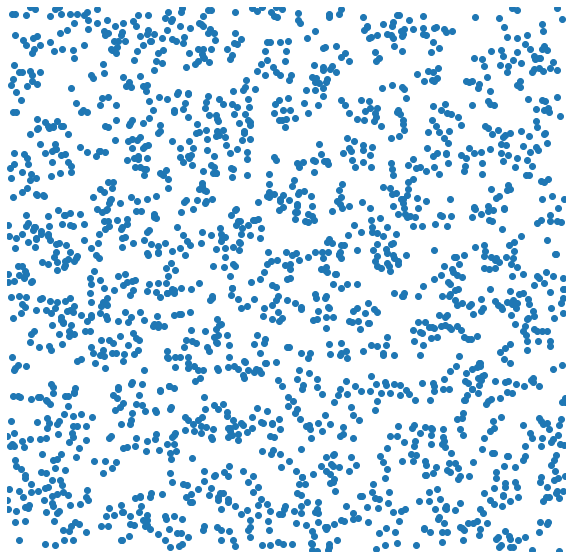

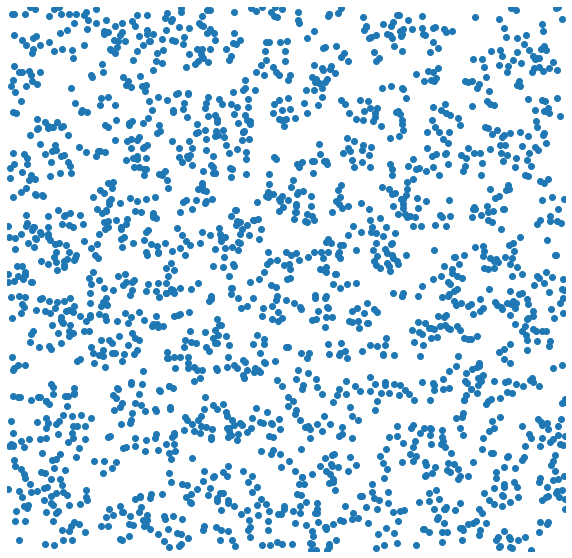

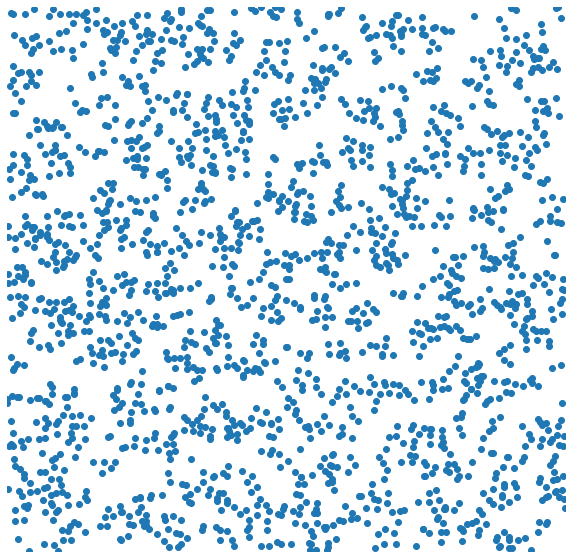

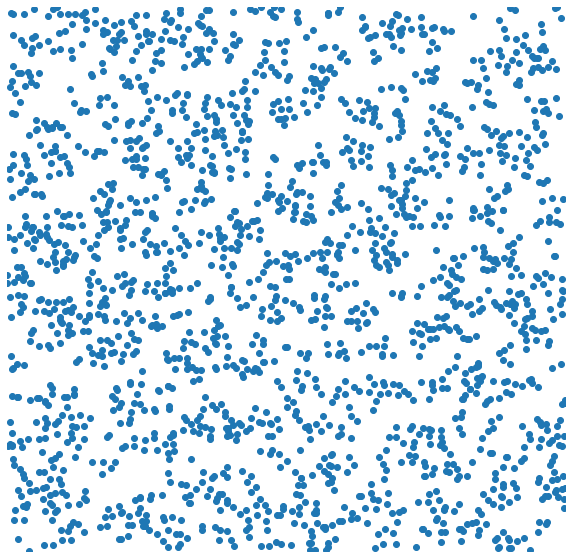

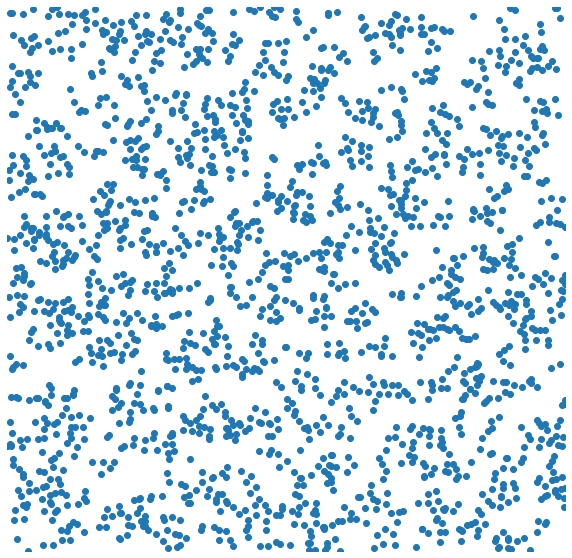

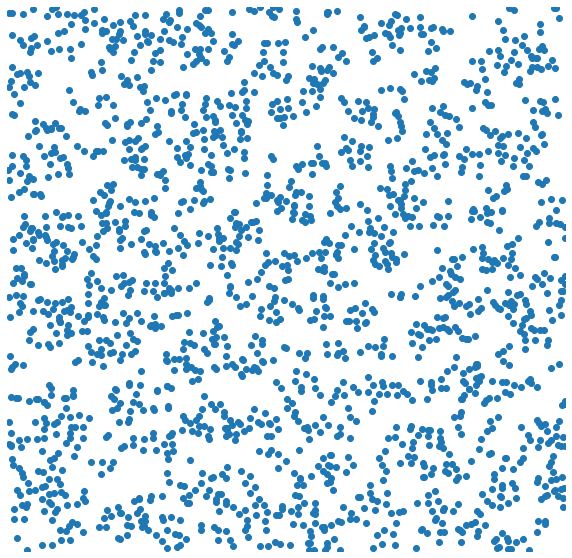

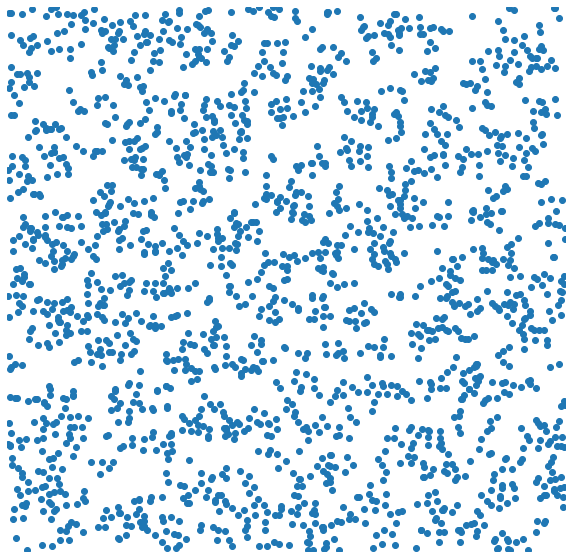

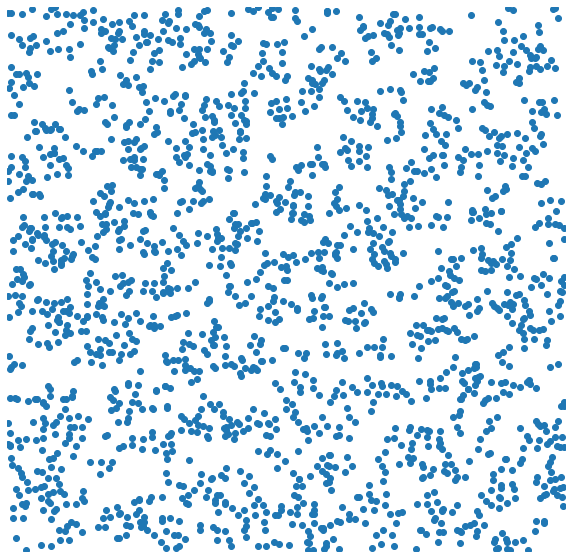

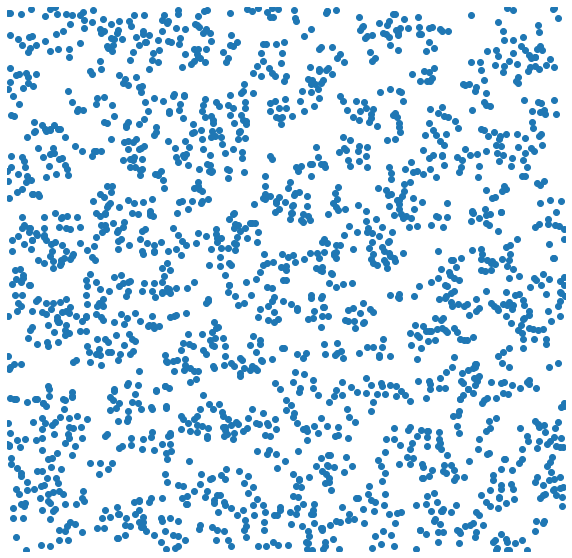

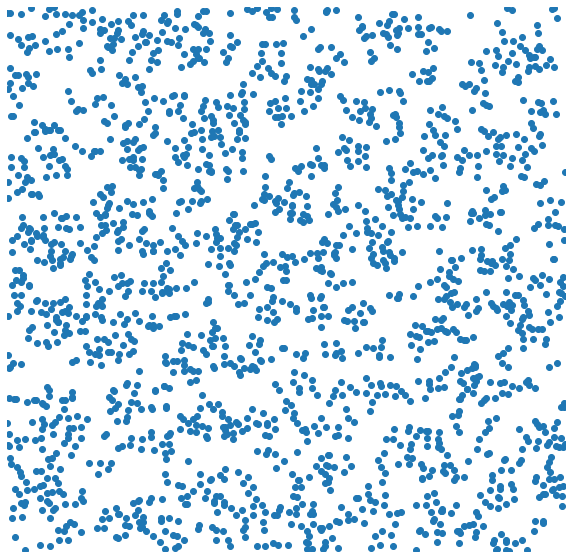

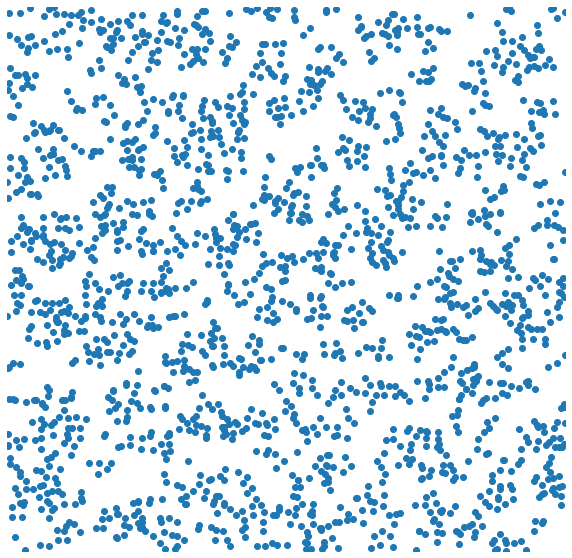

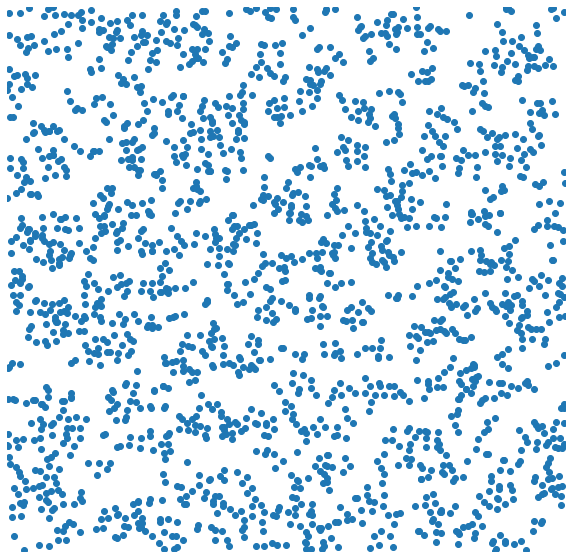

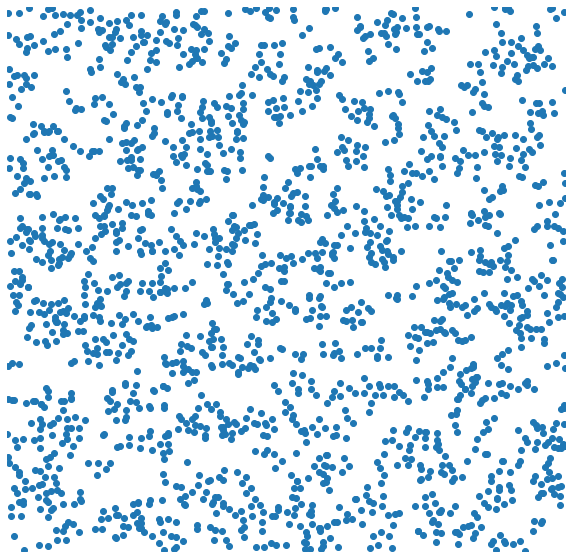

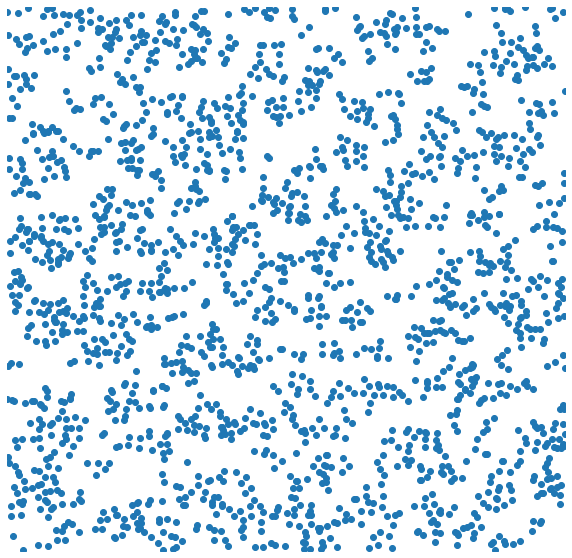

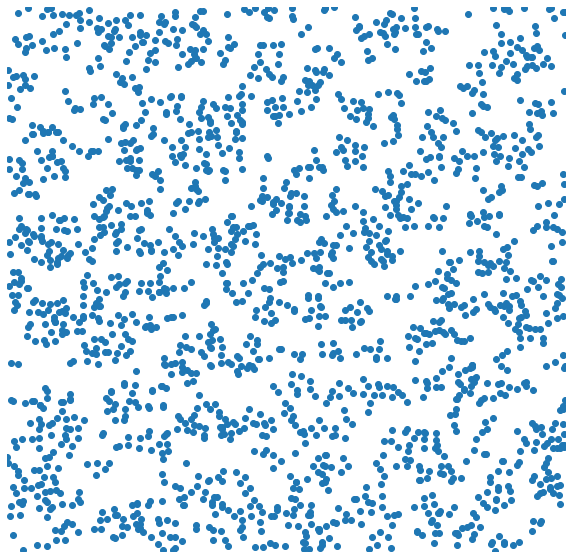

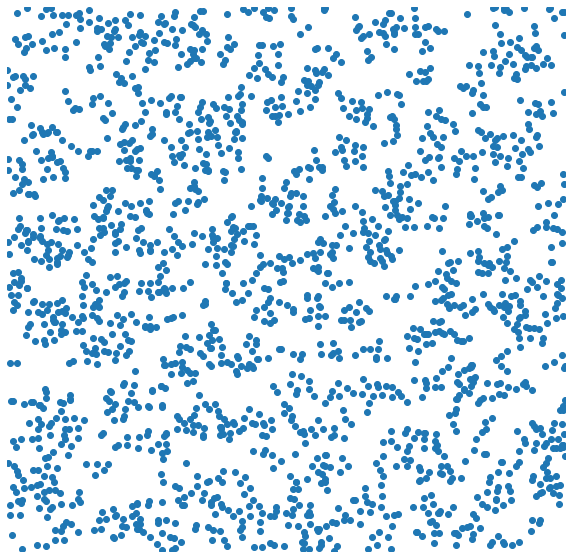

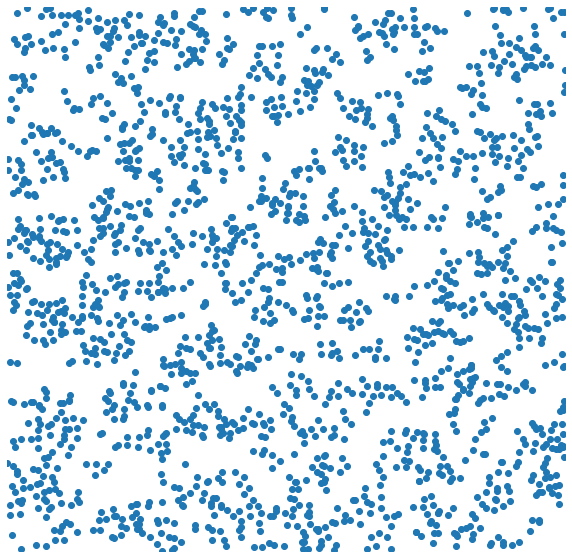

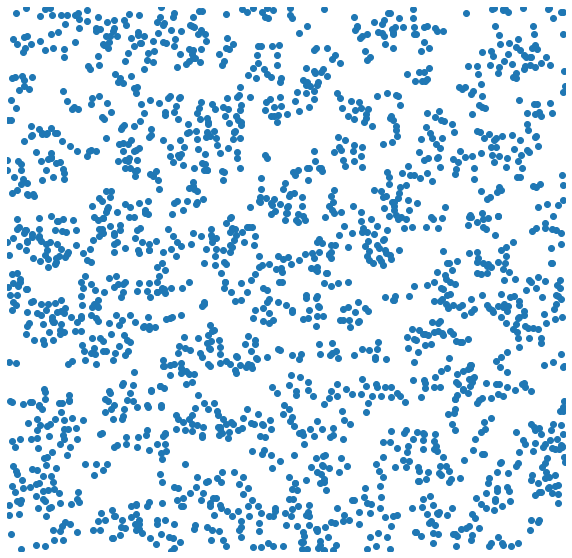

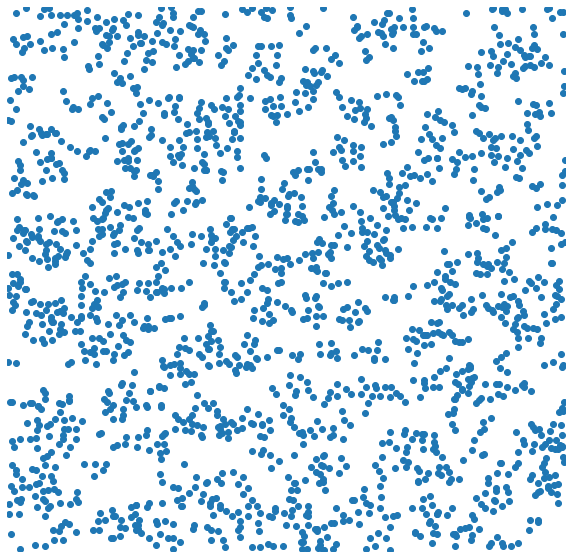

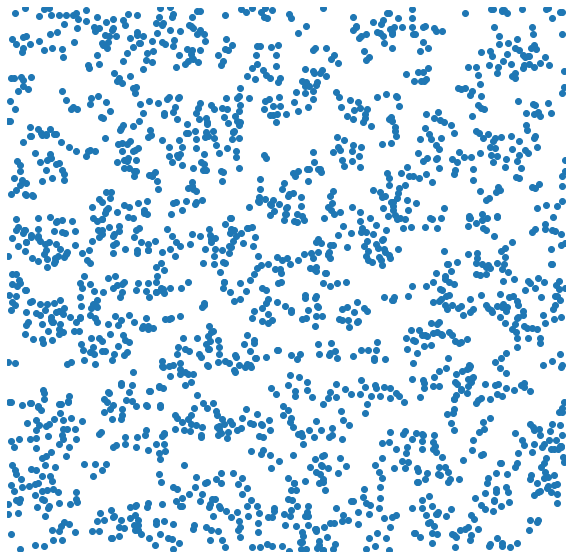

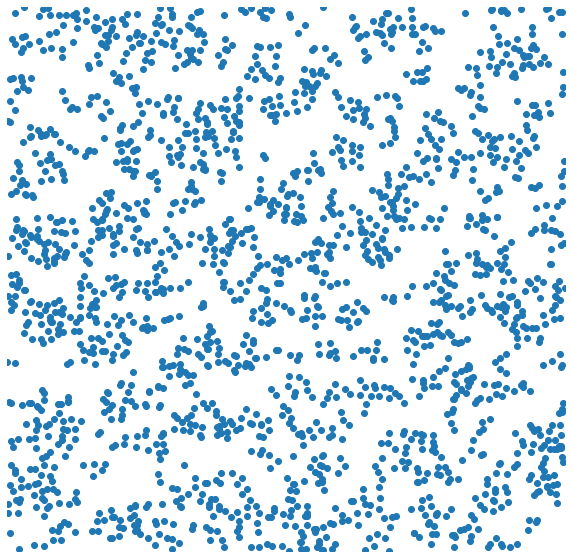

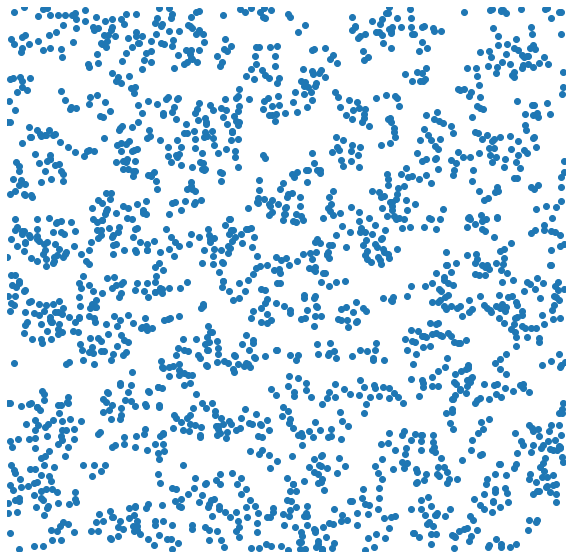

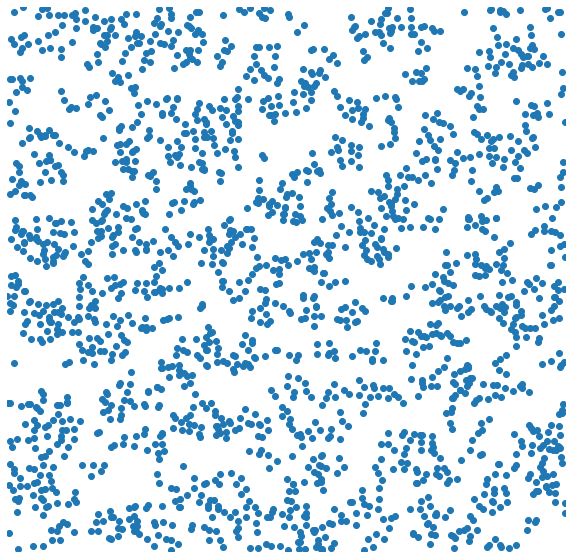

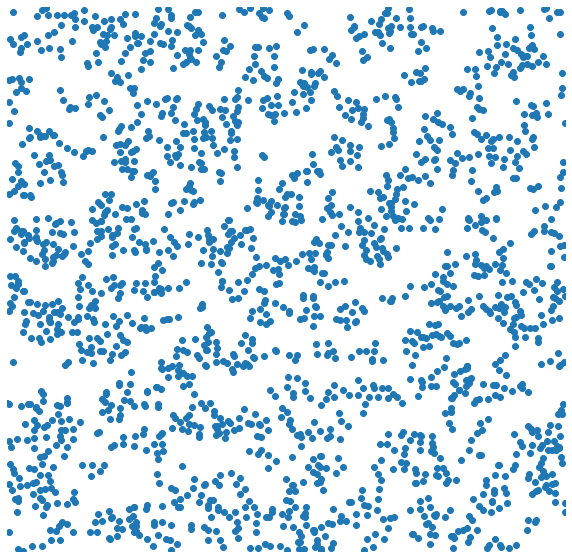

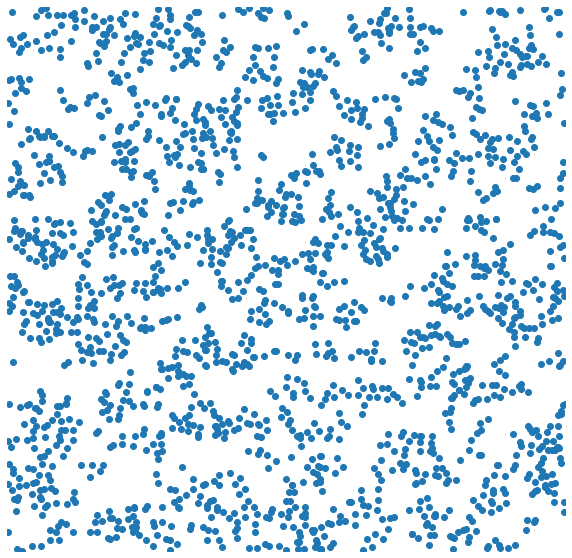

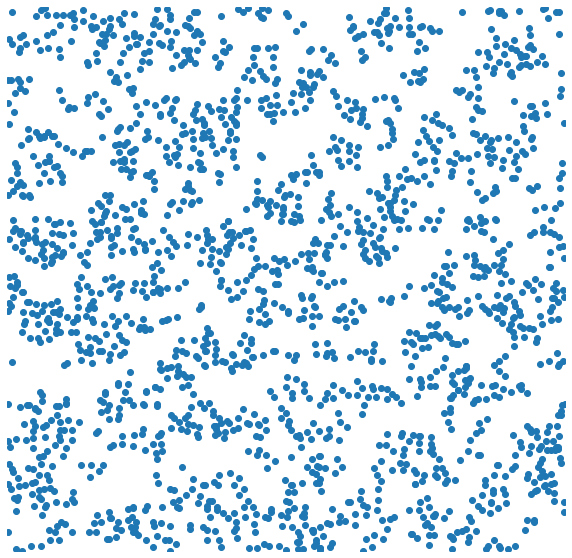

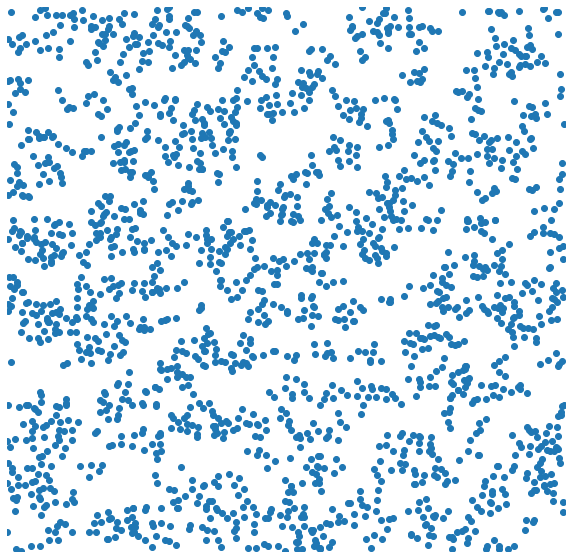

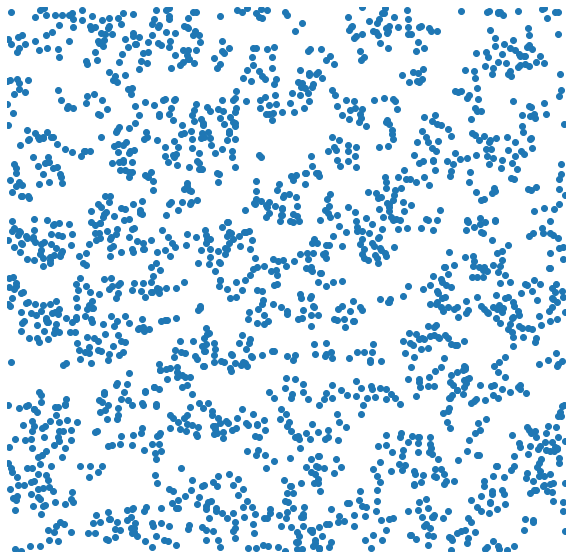

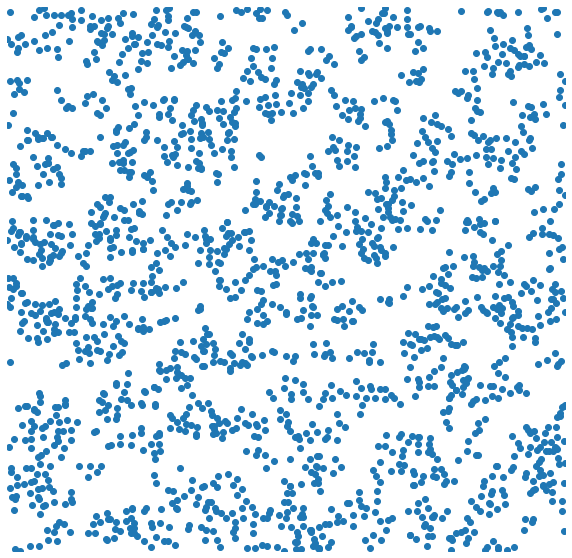

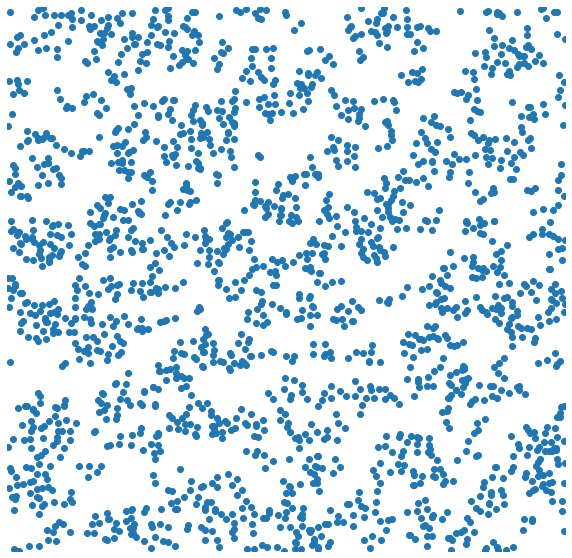

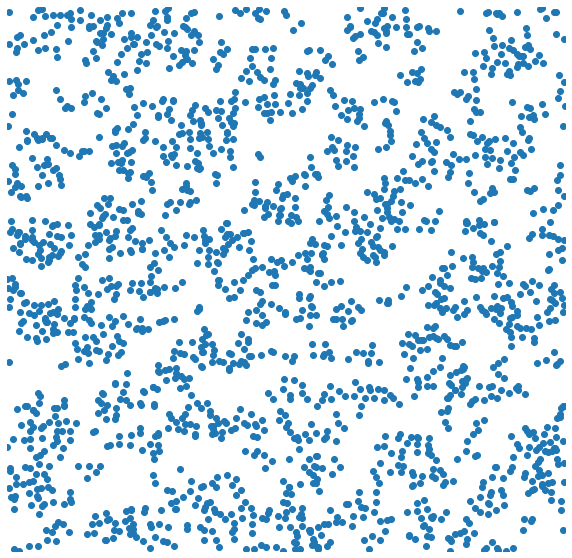

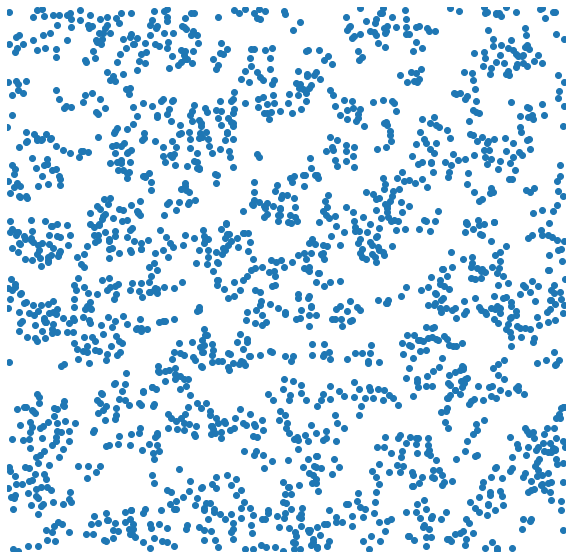

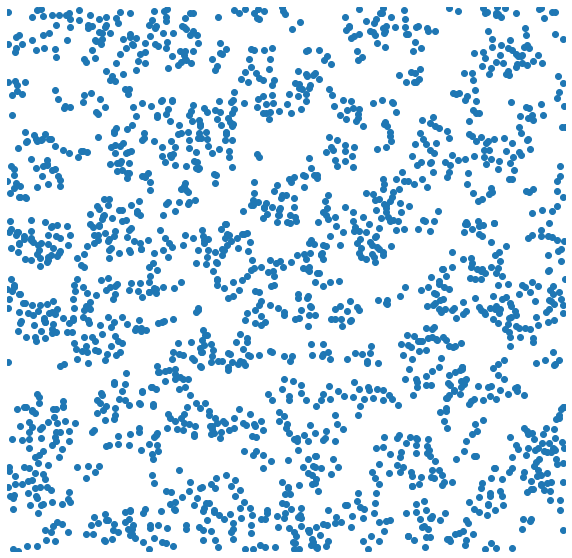

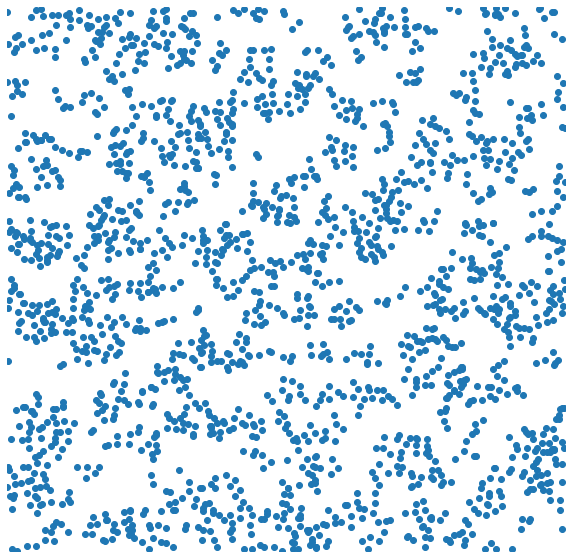

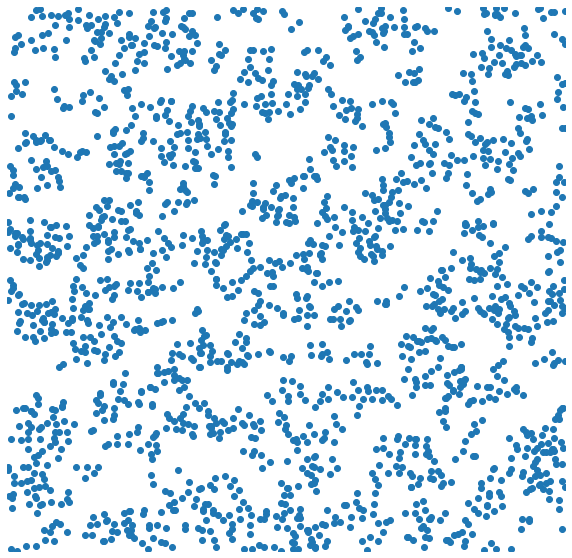

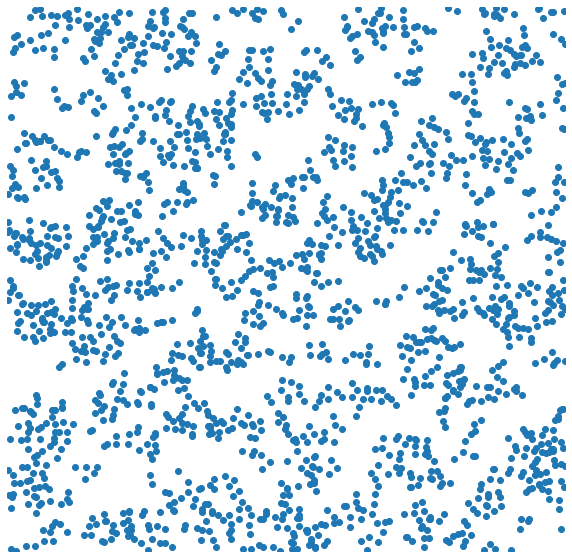

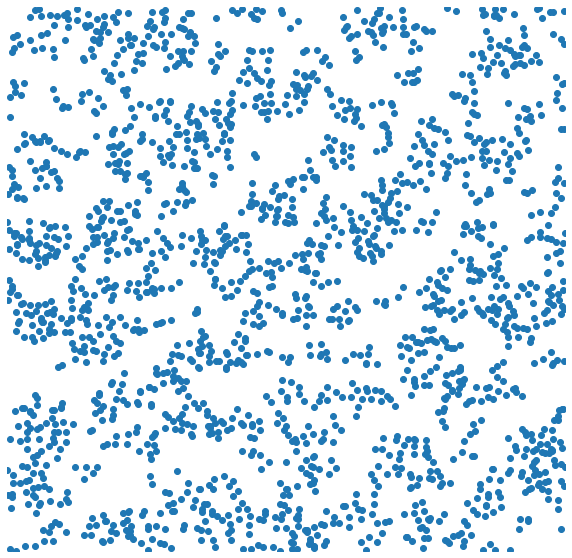

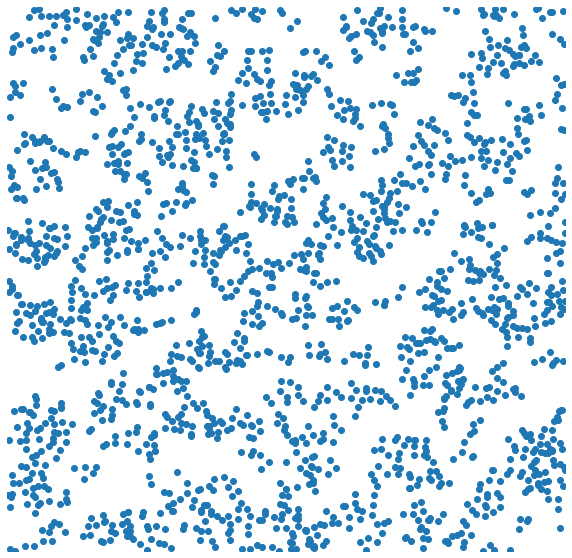

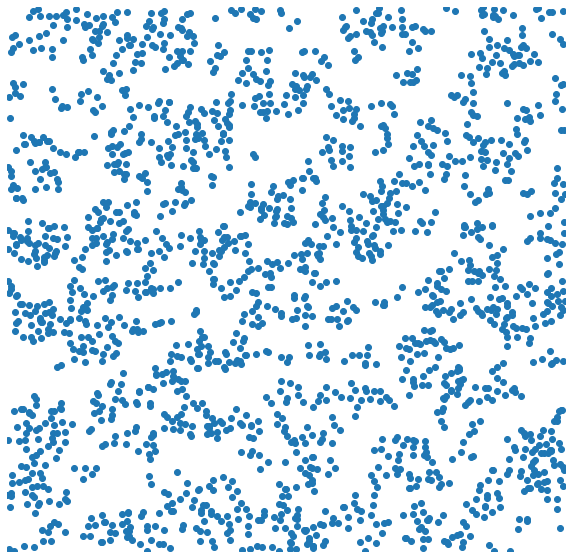

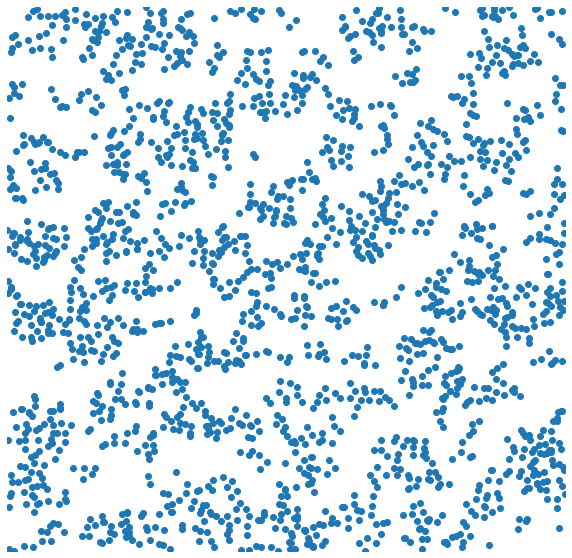

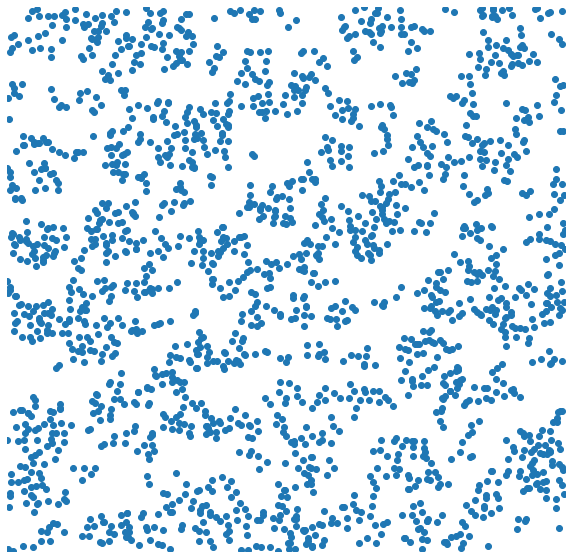

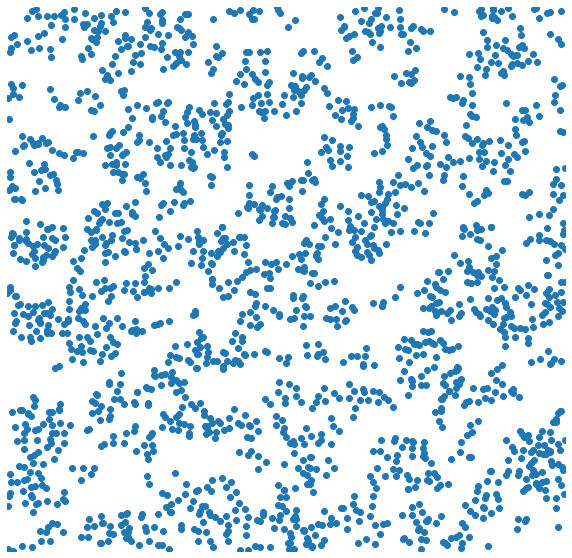

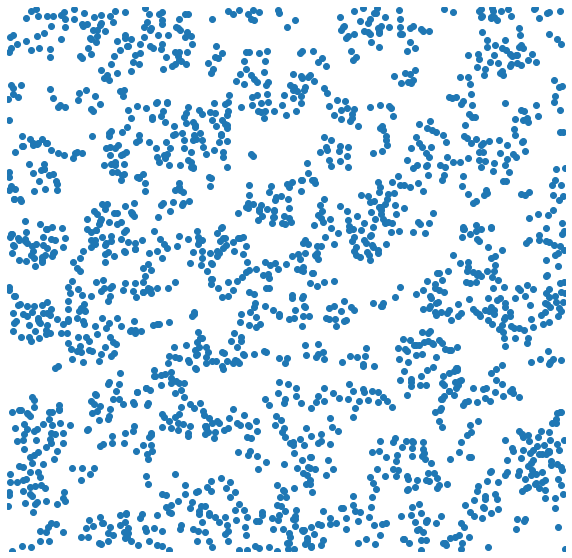

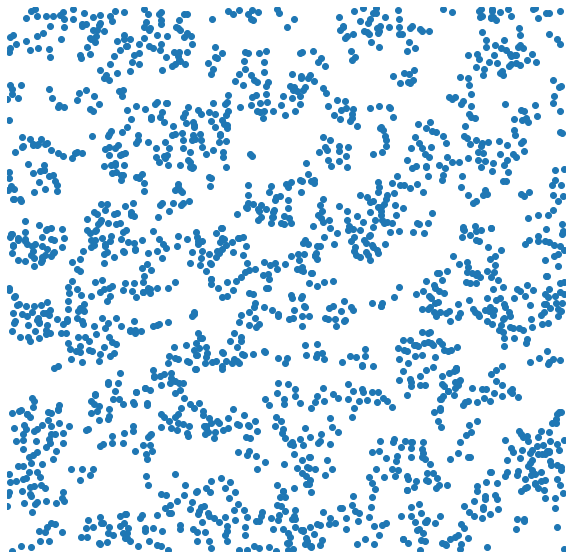

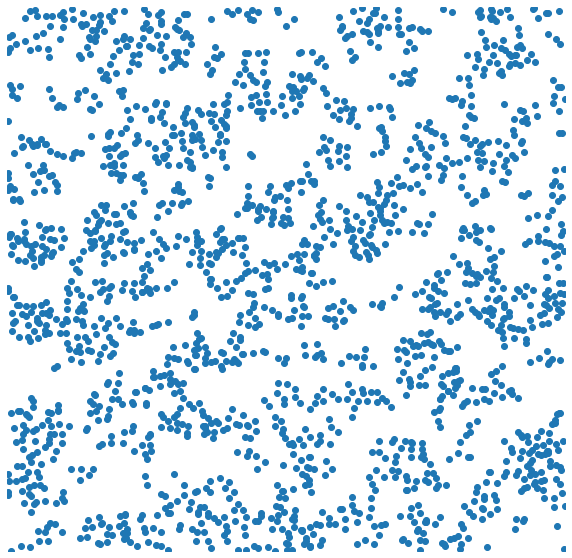

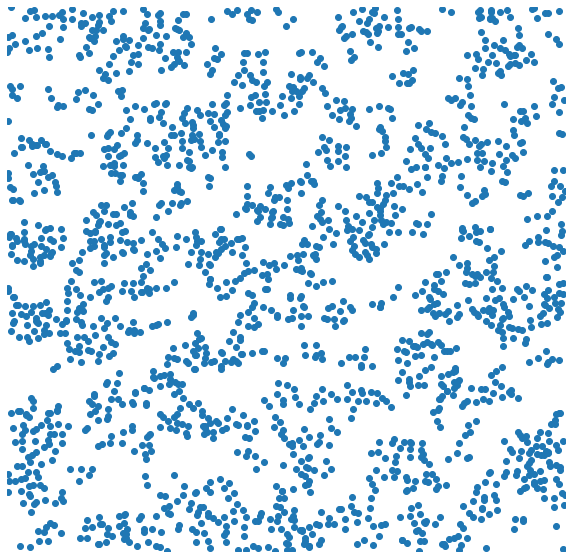

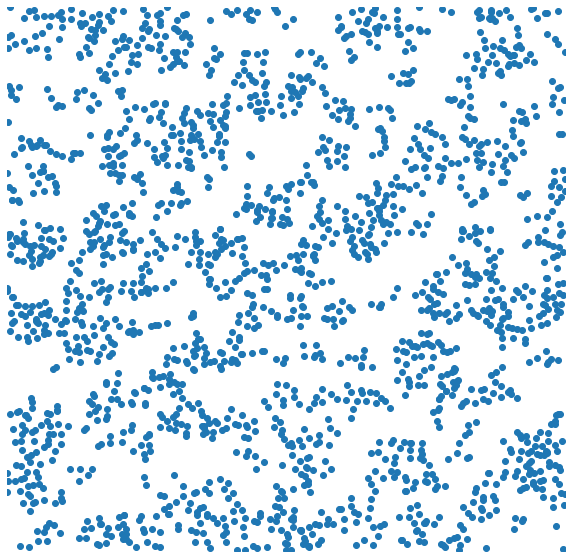

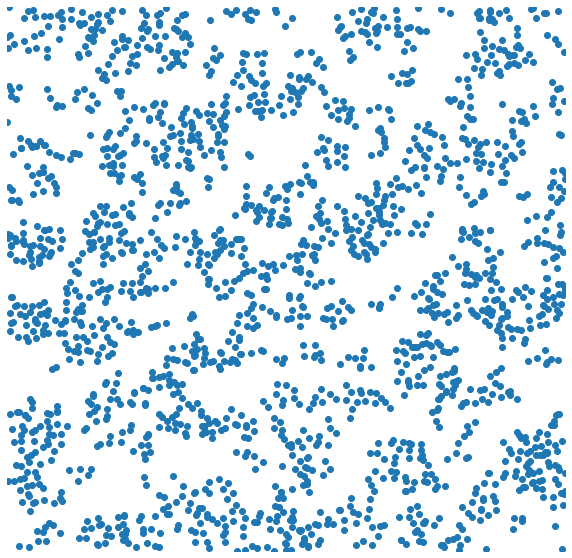

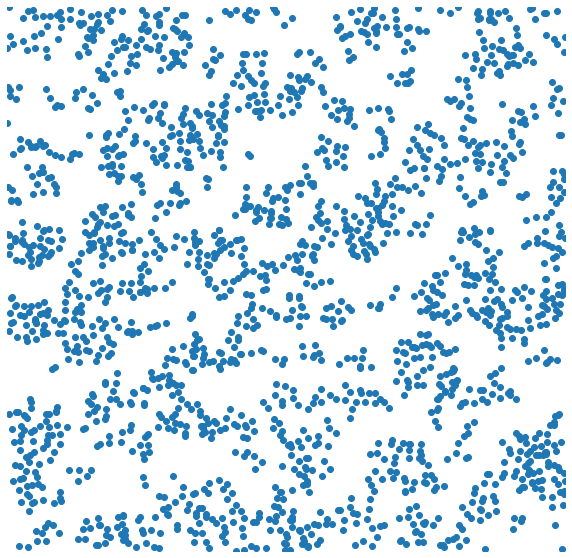

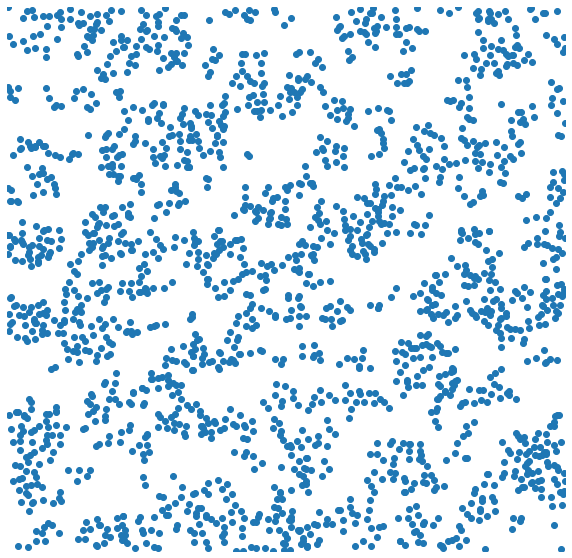

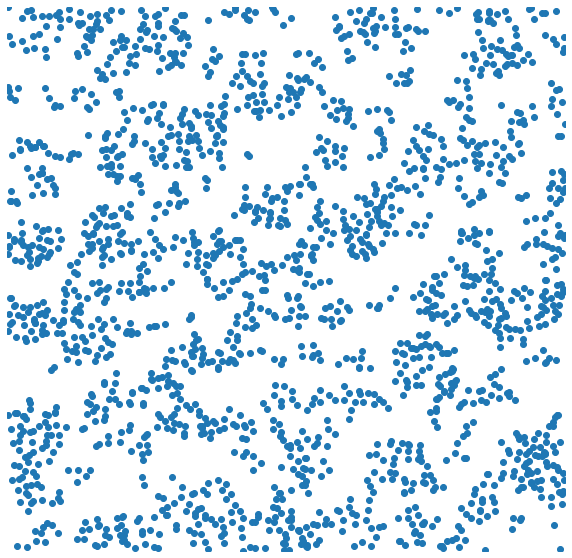

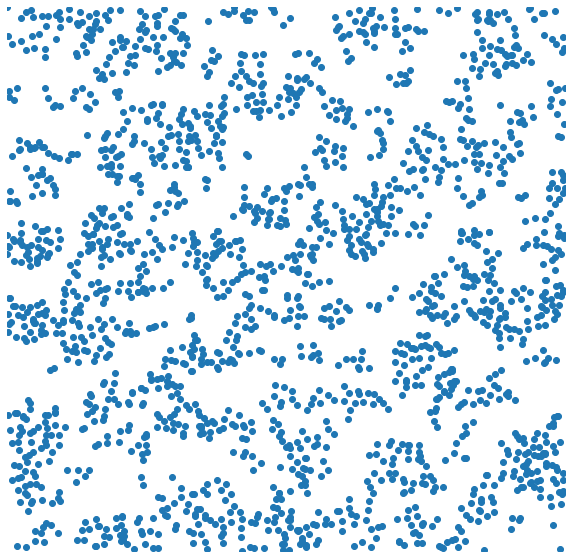

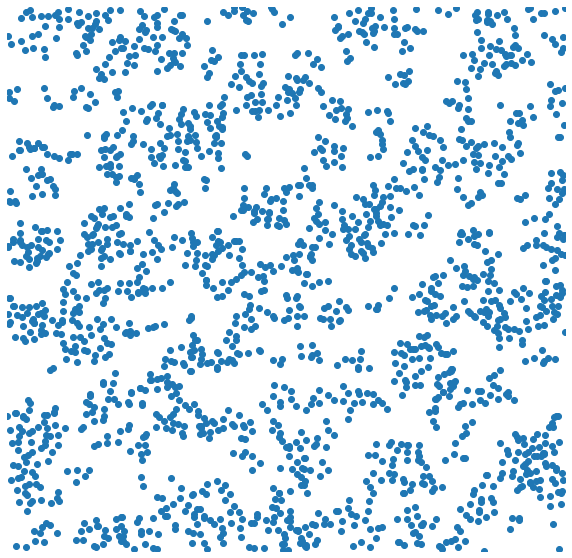

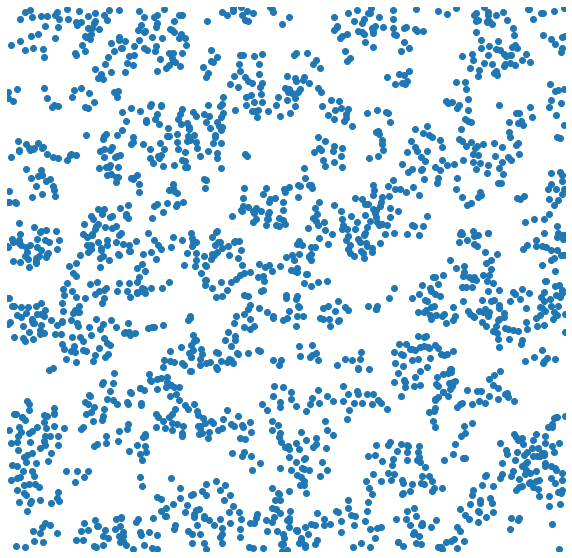

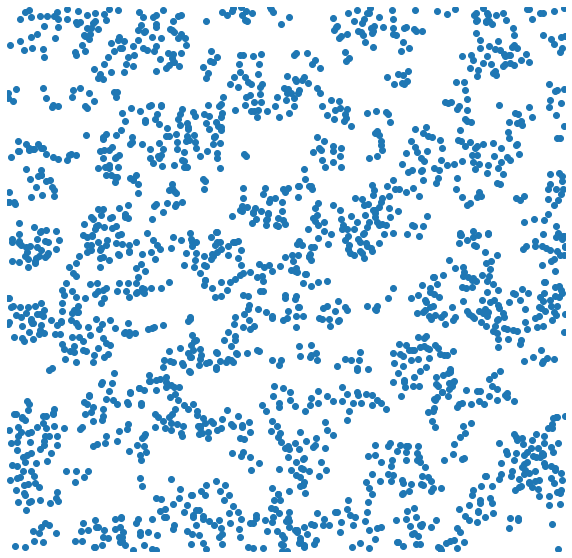

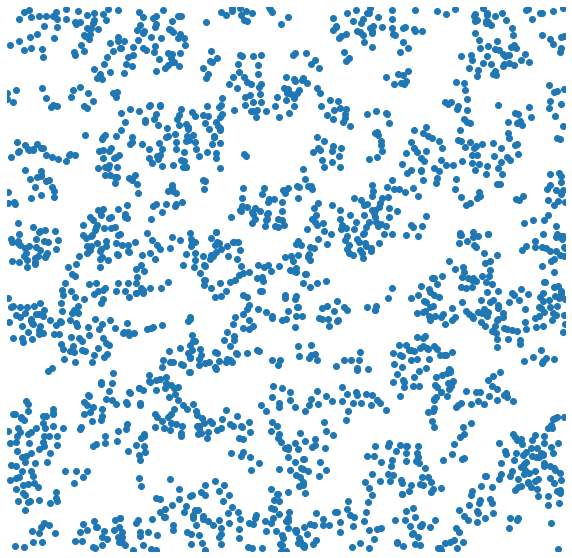

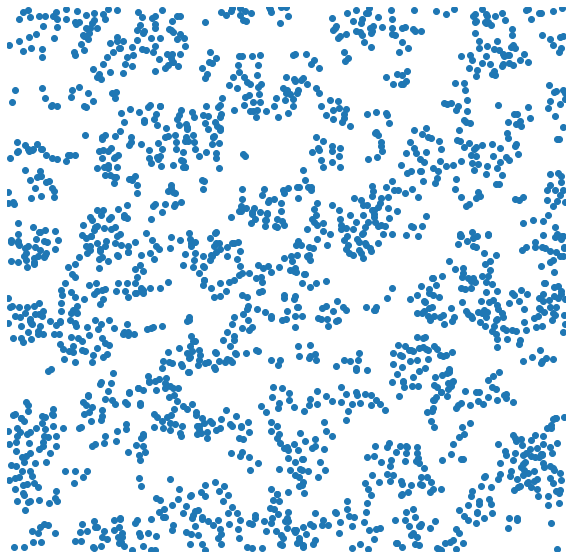

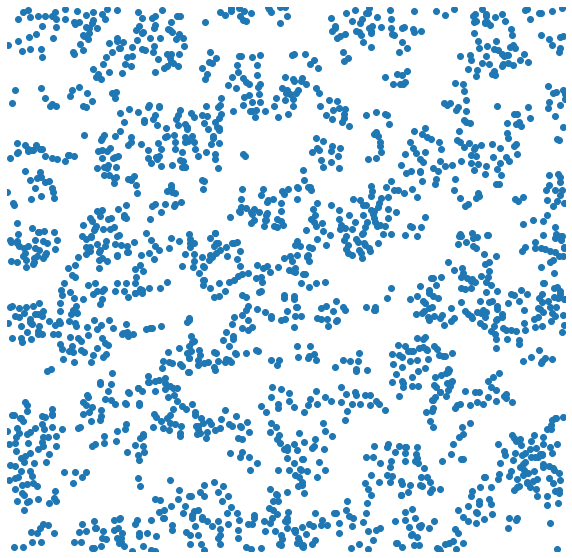

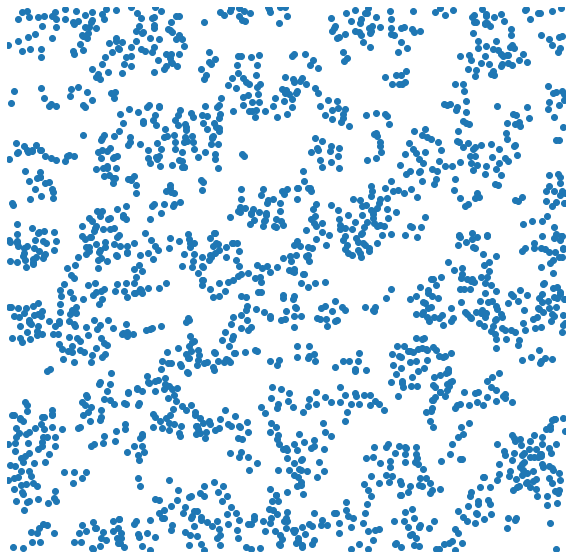

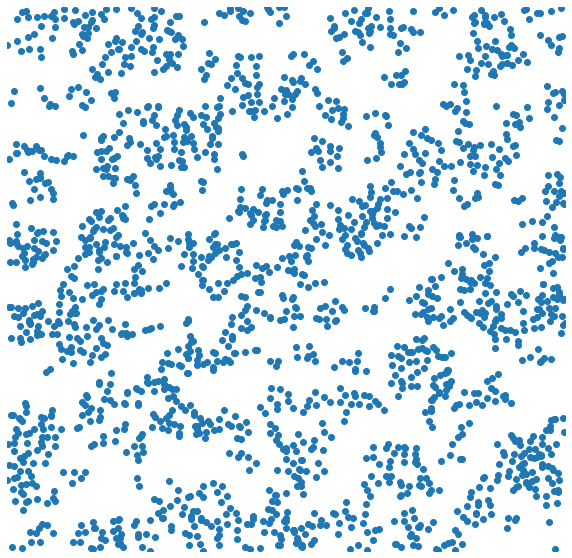

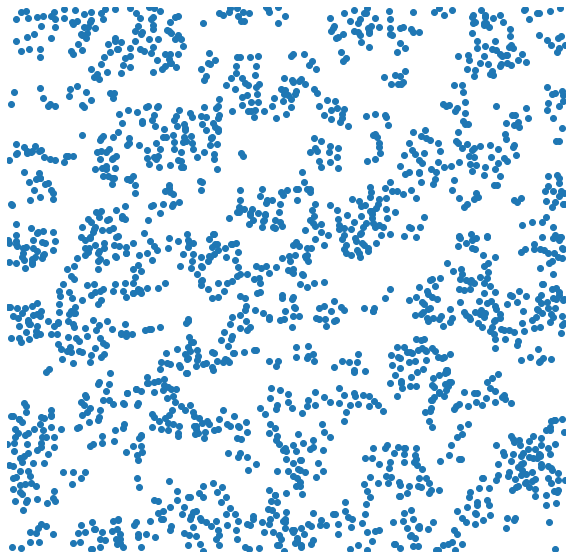

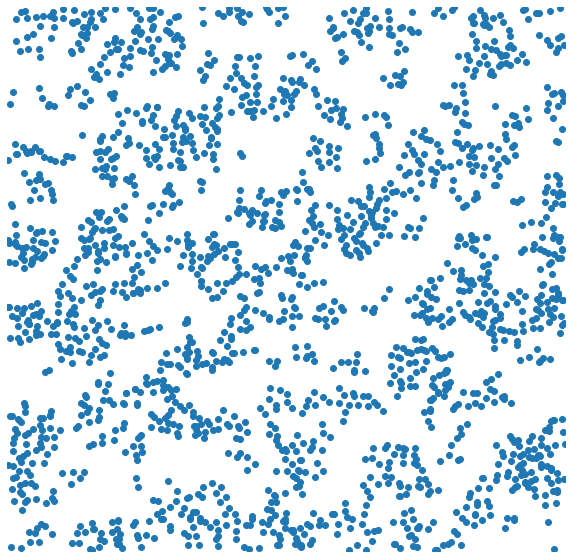

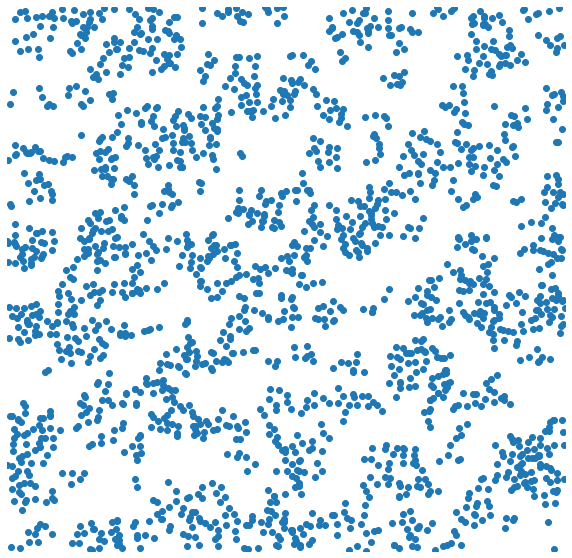

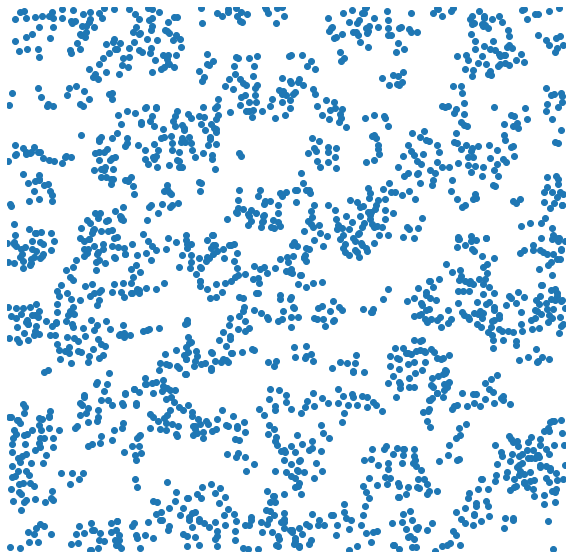

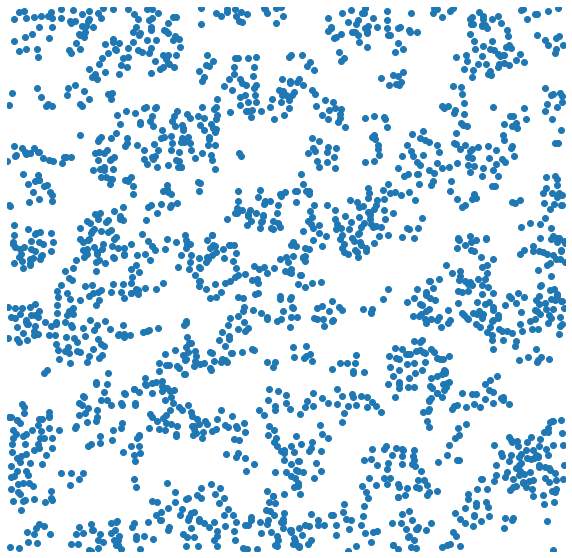

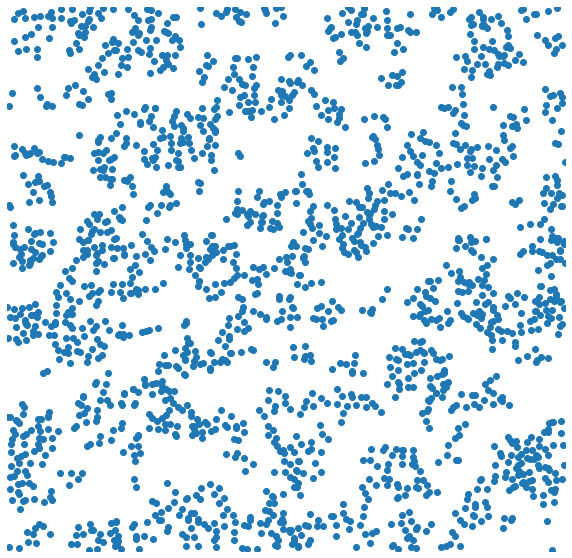

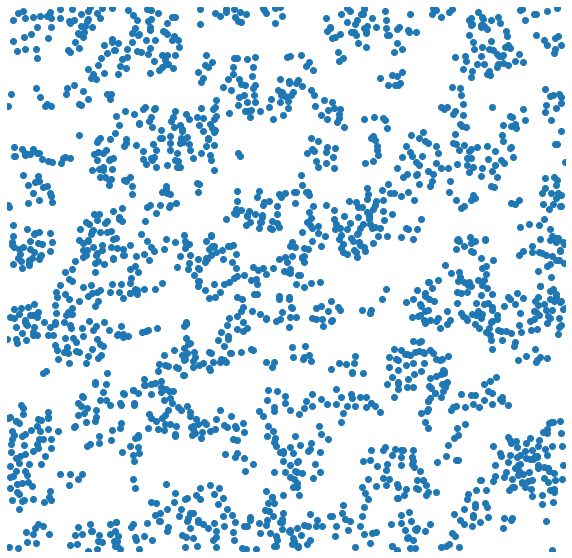

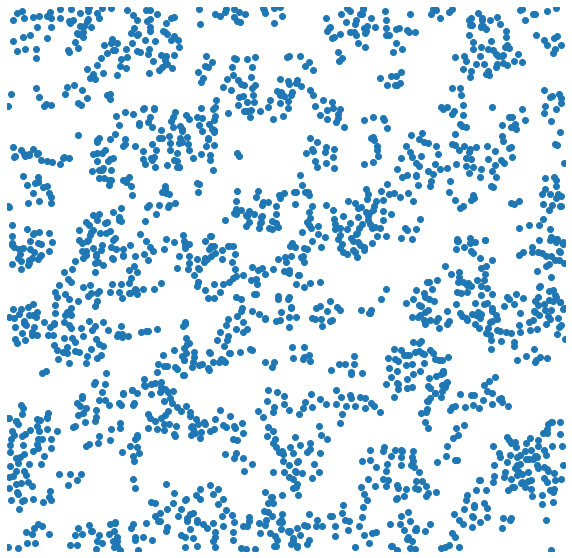

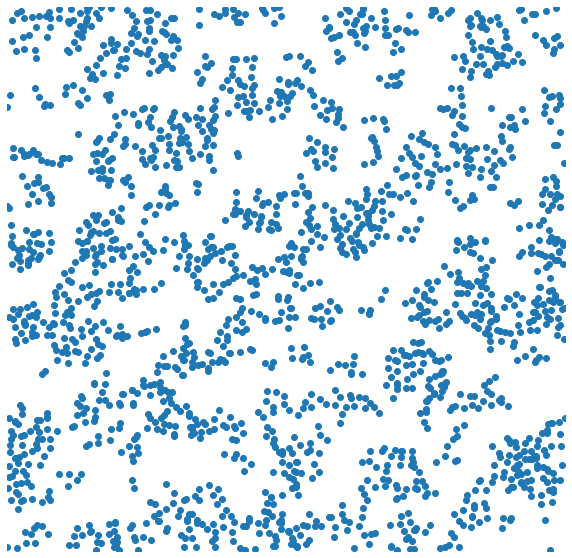

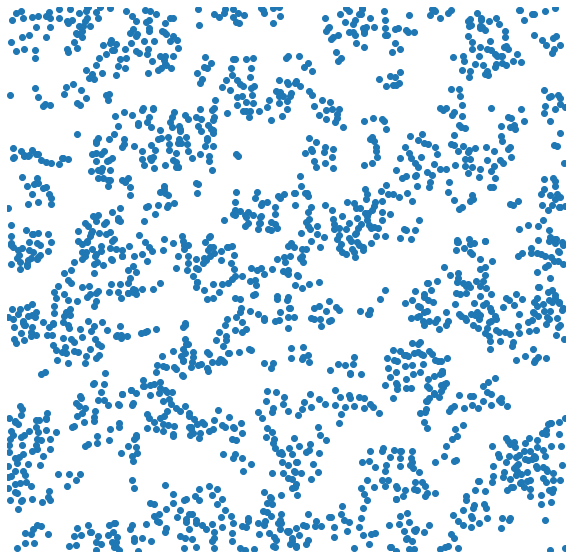

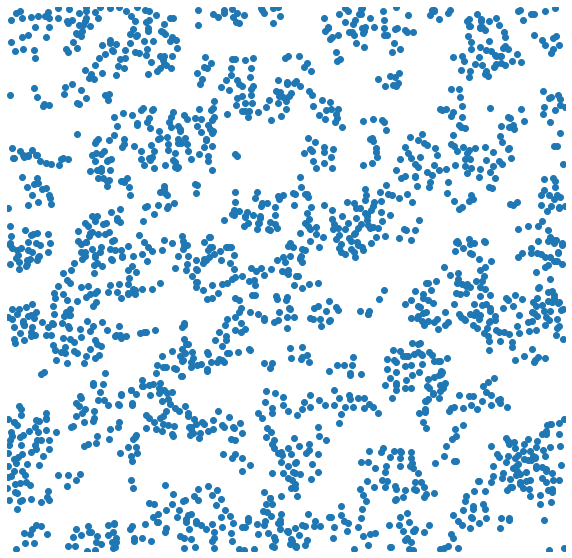

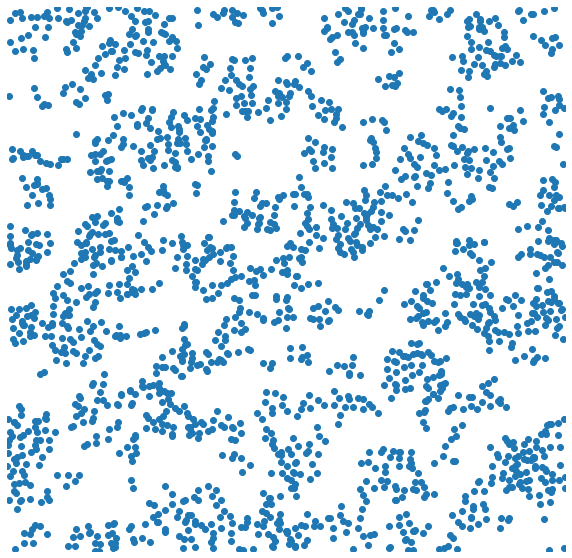

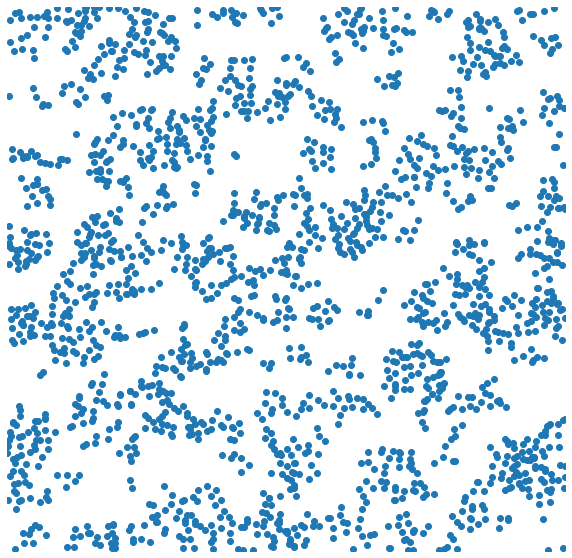

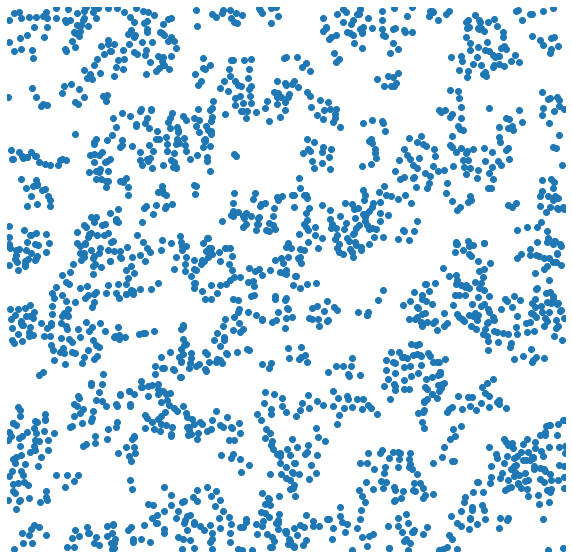

In [24]:
L = 100
N = 2000
v = 1
N_iter = 100
noise_mag=0.001
eps=2
vdt=0.1
get_flock_dynamics(N,L,noise_mag,eps,vdt,N_iter)